In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, UpSampling2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, zero_one_loss, balanced_accuracy_score, average_precision_score
from sklearn.metrics import classification_report
from inspect import signature
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import os
import pickle
import sys
import logging
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import backend

import seaborn as sns
from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE

from collections import Counter

In [8]:
##################################################################################################################
############################################ SEQUENTIAL ##########################################################
##################################################################################################################

In [2]:
backend.set_image_data_format('channels_first')

In [3]:
def get_vgg16():
    model = Sequential()

    # Encoder
    # Block 1
    model.add(BatchNormalization(axis=3, input_shape=(3, 176, 176)))
    #model.add(Dropout(.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block1_conv1', input_shape=(80,120,3)))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    # Block 2
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block2_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block3_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block3_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block4_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block4_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))


    # Block 5
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block5_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block5_conv2'))

    # Decoder
    # Block 6
    model.add(UpSampling2D((2, 2), name='block6_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block6_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block6_conv2'))

    # Block 7
    model.add(UpSampling2D((2, 2), name='block7_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block7_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block7_conv2'))

    # Block 8
    model.add(UpSampling2D((2, 2), name='block8_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block8_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block8_conv2'))

    # Block 9
    model.add(UpSampling2D((2, 2), name='block9_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block9_conv1'))
    model.add(BatchNormalization(axis=3))
    #model.add(Dropout(.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block9_conv2'))

    # Output
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(1, (1, 1), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block10_conv1'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mae', optimizer=sgd, metrics=['mse','acc'])
    #model.compile(loss='mae', optimizer=Adam(lr=0.001), metrics=['mse'])
    #model.compile(optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
    print(model.summary())

    return model

model = get_vgg16()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3, 176, 176)       704       
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 176, 176)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 176, 176)      704       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 176, 176)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 88, 88)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 88, 88)        352       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 88, 88)       7

In [4]:
X_train_dir = "/opt/datos/dataset/X_train.npy"
X_val_dir   = "/opt/datos/dataset/X_val.npy"
X_test_dir = "/opt/datos/dataset/X_test.npy"
Y_train_dir = "/opt/datos/dataset/Y_train.npy"
Y_val_dir   = "/opt/datos/dataset/Y_val.npy"

X_train = np.load(X_train_dir)
X_val   = np.load(X_val_dir)
X_test = np.load(X_test_dir)
Y_train = np.load(Y_train_dir)
Y_val   = np.load(Y_val_dir)

print("X_train: %s" %str(X_train.shape))
print("X_val: %s" %str(X_val.shape))
print("X_test: %s" %str(X_test.shape))
print("Y_train: %s" %str(Y_train.shape))
print("Y_val: %s" %str(Y_val.shape))

X_train: (2050, 3, 176, 176)
X_val: (439, 3, 176, 176)
X_test: (439, 3, 176, 176)
Y_train: (2050, 176, 176)
Y_val: (439, 176, 176)


In [17]:
vgghist = model.fit(X_train_us, Y_train_us, validation_data = (X_val,Y_val), epochs = 50)

Epoch 1/50
126/126 [==============================] - 219s 2s/step - loss: 0.5242 - mse: 0.5395 - acc: 0.1860 - val_loss: 0.0248 - val_mse: 0.0207 - val_acc: 0.9795
Epoch 2/50
126/126 [==============================] - 164s 1s/step - loss: 0.5113 - mse: 0.5068 - acc: 0.2639 - val_loss: 0.0251 - val_mse: 0.0208 - val_acc: 0.1381
Epoch 3/50
126/126 [==============================] - 164s 1s/step - loss: 0.5021 - mse: 0.4976 - acc: 0.1855 - val_loss: 0.0251 - val_mse: 0.0208 - val_acc: 0.1980
Epoch 4/50
126/126 [==============================] - 164s 1s/step - loss: 0.5104 - mse: 0.5059 - acc: 0.1959 - val_loss: 0.0251 - val_mse: 0.0208 - val_acc: 0.2907
Epoch 5/50
126/126 [==============================] - 164s 1s/step - loss: 0.5076 - mse: 0.5030 - acc: 0.2225 - val_loss: 0.0252 - val_mse: 0.0208 - val_acc: 0.2734
Epoch 6/50
126/126 [==============================] - 164s 1s/step - loss: 0.5016 - mse: 0.4970 - acc: 0.2155 - val_loss: 0.0256 - val_mse: 0.0209 - val_acc: 0.2317
Epoch 7/50

In [18]:
with open('trainHistoryDict_vgg16_smote', 'wb') as file_pi:
    pickle.dump(vgghist.history, file_pi)

In [6]:
with open('trainHistoryDict_vgg16', 'wb') as file_pi:
    pickle.dump(vgghist.history, file_pi)

In [5]:
history = pickle.load( open( "trainHistoryDict_vgg16_smote", "rb" ) )

In [4]:
history = pickle.load( open( "trainHistoryDict_vgg16", "rb" ) )

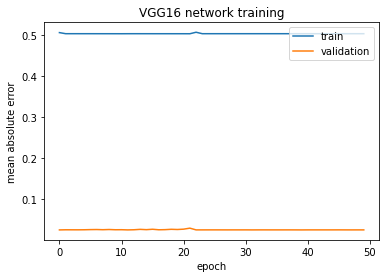

In [6]:
#print(history)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('VGG16 network training')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [6]:
y_pred = model.predict(X_test)


In [8]:
print(y_pred.shape)

(439, 1, 176, 176)


In [9]:
# Para ver que valores hay y cuantas veces aparece c/u
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
# Cargo en Y los valores reales de las matrices de tags, y le agrego una dim para coincidir con salida de la red
Y = np.load('/opt/datos/dataset/Y_test.npy')
#Y = np.expand_dims(Y,axis=1)

In [10]:
print(Y.shape)

(439, 176, 176)


In [8]:
# Cuento la cantidad de unos y ceros en las matrices de tags
lluvias = np.where(Y==1)[0].size
nolluvias = np.where(Y==0)[0].size

print("Cantidad de unos que hay realmente: " + str(lluvias))
print("Cantidad de ceros que hay realmente: " + str(nolluvias))
total_real = lluvias+nolluvias
print("Total: " + str(total_real))

Cantidad de unos que hay realmente: 497011
Cantidad de ceros que hay realmente: 13101453
Total: 13598464


In [9]:
# Cuento la cantidad de unos y ceros en las matrices de prediccion
#unos = np.where(y_pred == 1)[0].size
ceros = np.where(y_pred == 0)[0].size
value = np.where(y_pred != 0)[0].size

#print("Cantidad de unos predichos: " + str(unos))
print("Cantidad de ceros predichos: " + str(ceros))
print("Cantidad de valores distintos de cero: " + str(value))
total_real = value+ceros
print("Total: " + str(total_real))

Cantidad de ceros predichos: 12711421
Cantidad de valores distintos de cero: 887043
Total: 13598464


In [20]:
439*3*176*176

40795392

In [10]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

In [16]:
Y_falses = y_pred[Y==0]
Y_trues = y_pred[Y==1]
print(Y_falses.shape)
print(Y_trues.shape)

(13101453, 1)
(497011, 1)


(439, 176, 176)
(13598464,)
(439, 1, 176, 176)
(13598464,)
(13598464, 1)


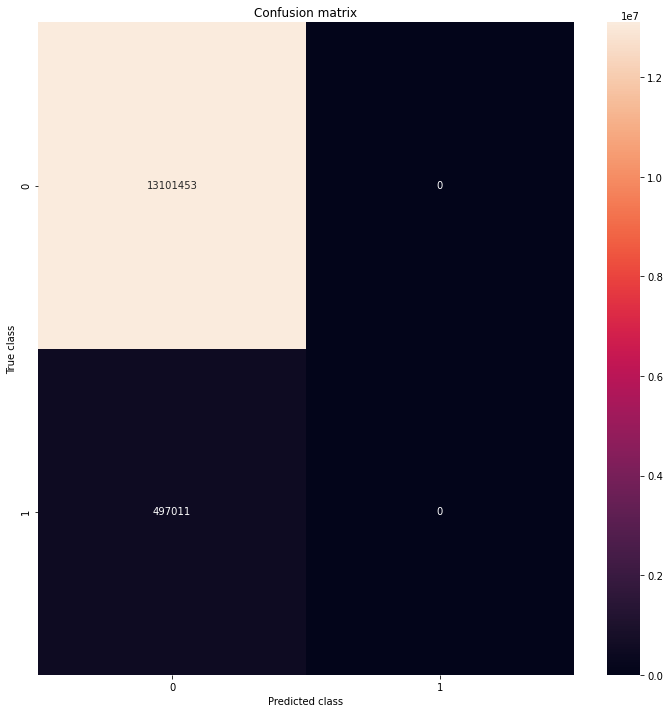

/home/Cavanagh_jf/miniconda3/envs/tf-gpu2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/Cavanagh_jf/miniconda3/envs/tf-gpu2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98  13101453
         1.0       0.00      0.00      0.00    497011

    accuracy                           0.96  13598464
   macro avg       0.48      0.50      0.49  13598464
weighted avg       0.93      0.96      0.95  13598464



/home/Cavanagh_jf/miniconda3/envs/tf-gpu2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
predije = ["0", "1"]

 
#definimos funciona para mostrar los resultados
def mostrar_resultados(Y_test, pred_y):
    conf_matrix = confusion_matrix(Y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=predije, yticklabels=predije, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(Y_test, pred_y))

#pred_y = model.predict(X_test_2d)

print(Y.shape)
#Y = np.reshape(Y,(Y.shape[0],176*176))
Y = Y.reshape(439*1*176*176)
print(Y.shape)

print(y_pred.shape)
#y_pred = np.reshape(y_pred,(y_pred.shape[0]*176*176))
y_pred = y_pred.reshape(439*1*176*176)
print(y_pred.shape)
y_pred=y_pred.reshape(-1,1)
print(y_pred.shape)

mostrar_resultados(Y, y_pred)

In [ ]:
#X_train: (2050, 3, 176, 176)
#X_val: (439, 3, 176, 176)
#X_test: (439, 3, 176, 176)
#Y_train: (2050, 176, 176)
#Y_val: (439, 176, 176)

Y_train_reply = np.empty((3,2050,176,176))
Y_test_reply = np.empty((3,439,176,176))

Y_train_reply[0] = Y_train
Y_train_reply[1] = Y_train
Y_train_reply[2] = Y_train

Y_test_reply[0] = Y
Y_test_reply[1] = Y
Y_test_reply[2] = Y

X_train_2d = X_train.reshape(2050*3*176*176)

X_test_2d = X_test.reshape(439*3*176*176)
Y_train_2d = Y_train_reply.reshape(2050*3*176*176)
Y_test_2d = Y_test_reply.reshape(439*3*176*176)

X_train_2d=X_train_2d.reshape(-1,1)
X_test_2d= X_test_2d.reshape(-1,1)

X_train_2d.shape

In [ ]:
print(X_train_2d.shape)
print(X_test_2d.shape)
print(Y_train_2d .shape)
print(Y_test_2d.shape)


In [5]:
X_train_0 = X_train[:,0,:,:]
X_train_1 = X_train[:,1,:,:]
X_train_2 = X_train[:,2,:,:]

In [6]:
print(X_train_0.shape)
print(X_train_1.shape)
print(X_train_2.shape)

(2050, 176, 176)
(2050, 176, 176)
(2050, 176, 176)


In [7]:
'''
Reshape

X_train_2d = X_train.reshape(2050*3*176*176)
X_test_2d = X_test.reshape(439*3*176*176)
Y_train_2d = Y_train_reply.reshape(2050*3*176*176)
Y_test_2d = Y_test_reply.reshape(439*3*176*176)
'''
X_train_0_2d = X_train_0.reshape(2050*176*176)
X_train_1_2d = X_train_1.reshape(2050*176*176)
X_train_2_2d = X_train_2.reshape(2050*176*176)
Y_train_2d   = Y_train.reshape(2050*176*176)

X_train_0_2d = X_train_0_2d.reshape(-1,1)
X_train_1_2d = X_train_1_2d.reshape(-1,1)
X_train_2_2d = X_train_2_2d.reshape(-1,1)

In [8]:
print(X_train_0_2d.shape)
print(X_train_1_2d.shape)
print(X_train_2_2d.shape)
print(Y_train_2d.shape)

(63500800, 1)
(63500800, 1)
(63500800, 1)
(63500800,)


In [20]:
# Calculo del porcentaje para balancear las clases

balance_ratio = 1.0
data0 = int(np.equal(Y_train_2d,0).sum())
data1 = int( data0 * balance_ratio )

print(data0)
print(data1)

62358560
62358560


In [10]:
# Cargo en Y los valores reales de las matrices de tags, y le agrego una dim para coincidir con salida de la red
Y = np.load('/opt/datos/dataset/Y_test.npy')

In [11]:
'''
Oversampling
'''

X_us_0, Y_us = SMOTE().fit_resample(X_train_0_2d, Y_train_2d)
print(sorted(Counter(Y_us).items()))
print(X_us_0.shape)
print(Y_us.shape)

X_us_1, Y_us = SMOTE().fit_resample(X_train_1_2d, Y_train_2d)
print(sorted(Counter(Y_us).items()))
print(X_us_1.shape)
print(Y_us.shape)

X_us_2, Y_us = SMOTE().fit_resample(X_train_2_2d, Y_train_2d)
print(sorted(Counter(Y_us).items()))
print(X_us_2.shape)
print(Y_us.shape)

[(0.0, 62358560), (1.0, 62358560)]
(124717120, 1)
(124717120,)
[(0.0, 62358560), (1.0, 62358560)]
(124717120, 1)
(124717120,)
[(0.0, 62358560), (1.0, 62358560)]
(124717120, 1)
(124717120,)


In [29]:
compare = Y_us_1==Y_us_2
igualdad = compare.all()
print(igualdad)

True


In [31]:
a = np.array([0,3,4])
b = np.array([3,4,0])

compare1 = a==b
igualdad1 = compare1.all()
print(igualdad1)

False


In [12]:
'''
rearmado matrices

-Se calcula el numero de valores que debe tener la matriz final, para cada dimension de la matriz X_train.
0:(4026*176*176)-1 ---> numero exacto de valores necesarios para obtener 4026 matrices.
'''

X_us_0 = X_us_0[0:(4026*176*176)]
X_us_1 = X_us_1[0:(4026*176*176)]
X_us_2 = X_us_2[0:(4026*176*176)]

X_us_0 = X_us_0.reshape(4026,176,176)
X_us_1 = X_us_1.reshape(4026,176,176)
X_us_2 = X_us_2.reshape(4026,176,176)


print(X_us_0.shape)
print(X_us_1.shape)

(4026, 176, 176)
(4026, 176, 176)


In [13]:
## para Y
Y_us = Y_us[0:(4026*176*176)]
Y_us = Y_us.reshape(4026,176,176)
print(Y_us.shape)

(4026, 176, 176)


In [14]:
X_train_us = np.empty((4026,3,176,176))
Y_train_us = np.empty((4026,176,176))

In [15]:
X_train_us[:,0,:,:] = X_us_0
X_train_us[:,1,:,:] = X_us_1
X_train_us[:,2,:,:] = X_us_2

Y_train_us = Y_us

In [16]:
print(X_train_us.shape)
print(Y_train_us.shape)

(4026, 3, 176, 176)
(4026, 176, 176)
